In [1]:
!pip install -q scikit-multiflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from skmultiflow.drift_detection import ADWIN, DDM
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from collections import deque, defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as mticker
from warnings import filterwarnings
from xgboost import XGBClassifier
from scipy.special import softmax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from typing import Callable
import tensorflow as tf
from sklearn import svm
from typing import List
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import pickle
import random
import keras
import copy
import json
import sys
import os
import gc
sns.set(rc = {'figure.figsize':(22,12)}, style="whitegrid")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
data_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data'
code_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Codes/Shared Codes'
results_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results'
feature_selection_results = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/feature_selection_results'
DriftLocation = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Drift Location'

In [5]:
sys.path.insert(0,code_path)
from genetic_programming import SymbolicRegressor,SymbolicClassifier
from binirizer import CustomLabelBinirizer
from ensemble import Ensemble, Classifier
from oselm import OSELMClassifier,set_use_know
from DynamicFeatureSelection import dynamic_feature_selection

In [6]:
def save_object(obj, filename,path):
    """
    _ INPUT (obj) THE OBJECT WE NEED SAVW IT (filename) THE NAME OF OBJECT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename,path):
    """
    _ INPUT THE NAME OF OBJECT WE NEED LOAD IT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [7]:
def prepare_data(csv_filename, target_column_name='class'):
    # read csv file
    df = pd.read_csv(csv_filename)
    df = df.iloc[:80000, :]
    column_names = df.columns.tolist()
    if target_column_name not in column_names:
        target_column_name = column_names[-1]
    # get unique value in target column
    unique_vlaues = sorted(df[target_column_name].unique().tolist())
    df[target_column_name] = df[target_column_name].apply(lambda x: 0 if x == unique_vlaues[0] else 1)
    df[target_column_name] = df[target_column_name].astype('int')
    # rename the column of the dataframe
    num_of_columns = len(column_names)
    df.columns = list(range(num_of_columns))
    return df

In [8]:
def genetic_programming():
    return SymbolicRegressor(population_size=10,
            generations=5, stopping_criteria=0.85,
            p_crossover=0.7, p_subtree_mutation=0.1,
            p_hoist_mutation=0.05, p_point_mutation=0.1,
            max_samples=0.7, verbose=0,
            parsimony_coefficient=1e-4, random_state=42,
            function_set=['avg2', 'avg3', 'avg5','median3', 'median5', 'maximum2', 'maximum3', 'maximum5'],
            metric='f1-score')

In [9]:
def generate_oselm_models(number_of_hidden_neurons, apply_model_replacement=False):
    models= [OSELMClassifier(number_of_hidden_neurons, 'relu', binarizer=CustomLabelBinirizer(), random_state=42),
             OSELMClassifier(number_of_hidden_neurons, 'relu', binarizer=CustomLabelBinirizer(), random_state=42),
             OSELMClassifier(number_of_hidden_neurons, 'relu', binarizer=CustomLabelBinirizer(), random_state=42),
             OSELMClassifier(number_of_hidden_neurons, 'relu', binarizer=CustomLabelBinirizer(), random_state=42),
             ]

    ensemble = Ensemble(classifiers=models, program=genetic_programming(), apply_model_replacement=apply_model_replacement)
    return ensemble

In [15]:
from sklearn.feature_selection import SelectFromModel
def random_forest_feature_selection(X, y):
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 3))
    sel.fit(X, y)
    return sel.get_support()

In [11]:
def generate_new_samples(buffer, y_values, n=500, y_col='label'):
    if not y_col in buffer.columns.tolist():
      y_col = buffer.columns.tolist()[-1]
    if y_values.sum() == 0:
       return buffer[buffer[y_col] == 1].sample(n, random_state=41)[:, :-1].values, np.array([1] * n)
    else:
      return buffer[buffer[y_col] == 0].sample(n,random_state=41)[:, :-1].values, np.array([0] * n)

In [12]:
def E2SC4ID(X,y,ensemble,drift_detection_obj):
  y_pred = ensemble.global_support_degree(X)
  if y is not None:
    drift = concept_drift_detection(drift_detection_obj, int(y!=y_pred))
    return drift
  return False

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
def model_evaluation(X_train, X_test, y_train, y_test, selected_features, methode_name):
    print(25*"-",methode_name,25*"-")
    if not selected_features is None:
      subset_features = np.where(np.array(selected_features) == 1)[0]
      if subset_features.shape[0] == 0:return [0,0,0,0,0]
      print(sum(selected_features))
      print(subset_features)
      X_train, X_test = X_train[:,subset_features], X_test[:,subset_features]
    model = OSELMClassifier(X_train.shape[1]*3 // 2, 'relu', binarizer=CustomLabelBinirizer(), random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f1,recall,precision,accuracy)
    return f1,recall,precision,accuracy,y_pred

In [ ]:
data_name = ['kddcup99','ISCX2012','CSE-CIC2018','CICIDS2017','7recurrentDrift', 'blip', 'incrementalDrift','7gradualDrift', '7suddenDrift']
filenames = ['kddcup99_csv.csv','ISCX2012.csv','CSE-CIC2018.csv','CICIDS2017.csv','7recurrentDrift.csv', 'blip.csv', 'incrementalDrift.csv',
             '7gradualDrift.csv', '7suddenDrift.csv']
filenames = list(map(lambda x: os.path.join(data_path, x), filenames))

for i,d_name in enumerate(data_name):
  datasets = {}
  drift_location = {}
  drift_detection_obj = DDM()
  d = prepare_data(filenames[i])
  d = d.sample(frac=1, random_state=42)
  buffer = d.sample(n=5000)
  d.reset_index(inplace=True)
  d.replace([np.inf], 0, inplace=True)
  datasets[filenames[i].split('/')[-1]] = d
  data = datasets[filenames[i].split('/')[-1]].values
  X, Y = data[:, 0:-1], data[:, -1].astype('int')
  ensemble = generate_oselm_models(number_of_hidden_neurons=X.shape[1]*3 // 2, apply_model_replacement=False)
  chunks_features = np.array_split(X, 10)
  chunks_labels = np.array_split(Y, 10)
  print(30*"*-",d_name,30*"*-")
  DFS_results_path = os.path.join(feature_selection_results,d_name)
  Drift_Location_path = os.path.join(DriftLocation,d_name)
  os.makedirs(Drift_Location_path, exist_ok=True)
  for chunk_number,chunk_X, chunk_Y in tqdm(zip([*range(len(chunks_labels))],chunks_features, chunks_labels)):
    print(25*"=",chunk_number,25*"=")
    drift = False
    try:
      chunk_X, chunk_Y = SMOTE().fit_resample(chunk_X, chunk_Y)
    except:
      if chunk_Y.sum() in [0, 1]:
        new_samples, new_labels = generate_new_samples(buffer, chunk_Y)
        chunk_X = np.concatenate((chunk_X, new_samples))
        chunk_Y = np.concatenate((chunk_Y, new_labels))
    gc.collect()

    if chunk_number > 0:
      for i in tqdm(range(len(chunk_X))):
        if drift:
          drift_location[chunk_number] = 'drift'
          break
        x, y_true = chunk_X[i], chunk_Y[i]
        drift = E2SC4ID(x,y_true,ensemble=ensemble,drift_detection_obj=drift_detection_obj)
    else:


    save_object(drift_location, "drift_location", Drift_Location_path)

    X_train, X_test, y_train, y_test = train_test_split(chunk_X, chunk_Y, random_state=42, train_size=0.80)
    model_evaluation(X_train, X_test, y_train, y_test, None, "with_out_fs")

    softmax_mask = load_object("softmax_mask_"+str(chunk_number),DFS_results_path)
    softmax_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, softmax_mask,"softmax")

    average_mask = load_object("average_mask_"+str(chunk_number),DFS_results_path)
    average_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, average_mask,"average")

    single_agent_mask = load_object("single_agent_mask_"+str(chunk_number),DFS_results_path)
    single_agent_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, single_agent_mask,"single_agent")

    random_forest_mask = load_object("random_forest_mask_"+str(chunk_number),DFS_results_path)
    random_forest_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, random_forest_mask,"random_forest")

    voting_mask = load_object("voting_mask_"+str(chunk_number),DFS_results_path)
    voting_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, voting_mask,"voting")

    # f1 = [softmax_f1,average_f1,single_agent_f1,random_forest_f1,voting_f1]
    # masks = [softmax_mask,average_mask,single_agent_mask,random_forest_mask,voting_mask]
    # max_f1 = max(f1)
    # best_mask = masks[f1.index(max_f1)]

    # save_object(best_mask, "best_mask_"+str(chunk_number), DFS_results_path)

    random_forest_ = np.array(random_forest_feature_selection(X_train, y_train))
    f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, random_forest_,"random_forest_")
    save_object(random_forest_, "random_forest_base_"+str(chunk_number), DFS_results_path)
    # best_f1,_,_,_,_ = model_evaluation(X_train, X_test, y_train, y_test, best_mask,"best")

In [ ]:

def E2SC4ID(X,y,ensemble,drift_detection_obj):
  y_pred = ensemble.global_support_degree(X)
  if y is not None:
    drift = concept_drift_detection(drift_detection_obj, int(y!=y_pred))
    return drift
  return False

def E2SC4ID_STREAM(ensemble, X, y, unselected_features, drift_detection_obj,
                   chunk_number, result_save_path_data,maxC=4,train_size=0.8,drift=False,transfer_learning=True):
    if chunk_number==1 or not transfer_learning:
      ensemble.fit(X, y)
      return ensemble,drift_detection_obj
    if drift:
      drift_detection_obj.reset()
      X_train,X_valid,y_train,y_valid = train_test_split(X, y, random_state=42, train_size=train_size)

      new_models = ensemble.classifier_induction([model for model in create_list_of_oselm_models(number_of_hidden_neurons=X.shape[1]*3 // 2)]
                                                  ,X_train,y_train,unselected_features)
      if len(ensemble.classifiers) >= maxC:
          ensemble.model_replacement('time')
      ensemble.update_program(X_valid, y_valid)
    else:
      ensemble.fit(X, y)
    return ensemble, drift_detection_obj

def main(f_name, generate_model, train_size=0.8,apply_model_replacement=False,transfer_learning=False,
         feature_selection=[], result_save_path="",DFS_results_path='',ChunkNumber=0):
  datasets = {}
  d = prepare_data(f_name)
  d = d.sample(frac=1, random_state=42)
  buffer = d.sample(n=5000)
  d.reset_index(inplace=True)
  d.replace([np.inf], 0, inplace=True)
  datasets[f_name.split('/')[-1]] = d
  results = {}
  # drift_locations_in_all_dataset = {}
  ensemble = None
  drift_detection_obj = DDM()
  for key in tqdm(datasets.keys()):
      result_save_path_data = os.path.join(result_save_path, key)
      drift_location = {}
      prediction_times = {}
      memory_reduction = {}

      results[key] = {'model_result': []}
      data = datasets[key].values
      X, Y = data[:, 0:-1], data[:, -1].astype('int')
      if not os.path.exists("{}_evolving_matrix.pkl".format(os.path.join(evolving_path, key))):
        a2 = np.random.randint(low=0, high=X.shape[1], size = X.shape[1] // 6).tolist()
        a3 = np.random.randint(low=0, high=X.shape[1], size = X.shape[1] // 5).tolist()
        a4 = np.random.randint(low=0, high=X.shape[1], size = X.shape[1] // 4).tolist()
        evolving_matrix = [a2, a3, a4]
        save_pickle(evolving_matrix, "{}_evolving_matrix.pkl".format(os.path.join(evolving_path, key)))
      else:
        evolving_matrix = load_pickle("{}_evolving_matrix.pkl".format(os.path.join(evolving_path, key)))
      ensemble = generate_model(number_of_hidden_neurons=X.shape[1]*3 // 2, apply_model_replacement=apply_model_replacement)
      chunks_features = np.array_split(X, 10)
      chunks_labels = np.array_split(Y, 10)
      print("===================== dataset : {} ======================".format(key))
      chunk_number = 1
      for CN,chunk_X, chunk_Y in tqdm(zip([*range(len(chunks_labels))],chunks_features, chunks_labels)):
          drift = False
          if ChunkNumber > CN:
            print("Skip Chunk Number : {}".format(CN))
            continue
          try:
            chunk_X, chunk_Y = SMOTE().fit_resample(chunk_X, chunk_Y)
          except:
            if chunk_Y.sum() in [0, 1]:
              new_samples, new_labels = generate_new_samples(buffer, chunk_Y)
              chunk_X = np.concatenate((chunk_X, new_samples))
              chunk_Y = np.concatenate((chunk_Y, new_labels))
          gc.collect()

          unselected_feautres = None
          selected = None
          Drift_Location_path = os.path.join(DriftLocation,key)
          if not os.path.exists(os.path.join(DriftLocation, "drift_location")):
            os.makedirs(Drift_Location_path, exist_ok=True)
            if chunk_number > 1:
              for i in tqdm(range(len(chunk_X))):
                if drift:
                  drift_location[chunk_number] = 'drift'
                  break
                x, y_true = chunk_X[i], chunk_Y[i]
                drift = E2SC4ID(x,y_true,ensemble=ensemble,drift_detection_obj=drift_detection_obj)
            save_object(drift_location, "drift_location", Drift_Location_path)
          else:
            save_object(drift_location, "drift_location", Drift_Location_path)
            drift = None
          X_train, X_test, y_train, y_test = train_test_split(chunk_X, chunk_Y, random_state=42, train_size=train_size)
          if feature_selection[0] == "feature_evolving":
            unselected_feautres = feature_evolving(evolving_matrix=evolving_matrix)
            if feature_selection[1] == "random_forest":
              print("Evolving RandomForest")
              selected = np.array(random_forest_feature_selection(X_train, y_train))
              selected1 = np.delete(selected, unselected_feautres)
              if sum(selected1)!=0:
                selected=selected1
                X_train = np.delete(X_train, unselected_feautres, 1)
                X_test = np.delete(X_test, unselected_feautres, 1)
              unselected_feautres = np.where(selected != 1)[0]
            elif feature_selection[1] == "DFS_feature_selection":
              print("Evolving DFS")
              X_train = np.delete(X_train, unselected_feautres, 1)
              X_test = np.delete(X_test, unselected_feautres, 1)
              selected = load_best_mask_dfs(CN,DFS_results_path)
              selected = np.delete(selected, unselected_feautres)
              unselected_feautres = np.where(selected != 1)[0]
            else:
              print("Without Any FS")
              X_train = np.delete(X_train, unselected_feautres, 1)
              X_test = np.delete(X_test, unselected_feautres, 1)
              selected = None
          else:
            if feature_selection[1] == "random_forest":
              print("RandomForest")
              selected = random_forest_feature_selection(X_train, y_train)
              unselected_feautres = np.where(selected != 1)[0]
            elif feature_selection[1] == "DFS_feature_selection":
              print("DFS")
              selected = load_best_mask_dfs(CN,DFS_results_path)
              unselected_feautres = np.where(selected != 1)[0]
            else:
              print("Without Any FS")
              selected = None
              unselected_feautres = None

          selected = [bool(bit) for bit in selected] if not selected is None else None
          if not os.path.exists(result_save_path_data):
            os.mkdir(result_save_path_data)
          if transfer_learning:
            if not selected is None:temp = np.squeeze(X_train[:, selected]) if len(list(X_train[:, selected].shape))>2 else X_train[:, selected]
            else:temp = X_train

            ensemble,drift_detection_obj = E2SC4ID_STREAM(ensemble=ensemble, X=temp, y=y_train, unselected_features=None,drift_detection_obj=drift_detection_obj,
                                      chunk_number=chunk_number, result_save_path_data=result_save_path_data,drift=drift , transfer_learning=transfer_learning)
            if not selected is None:temp = np.squeeze(X_test[:, selected]) if len(list(X_test[:, selected].shape))>2 else X_test[:, selected]
            else:temp = X_test
            ensemble.evaluate(temp, y_test, chunk_number)
          else:
            init_ensemble=generate_model(number_of_hidden_neurons=X.shape[1]*3 // 2,apply_model_replacement=apply_model_replacement)
            if not ensemble is None:
              init_ensemble.set_scores(ensemble.get_scores())
            ensemble,drift_detection_obj = E2SC4ID_STREAM(ensemble=init_ensemble,X=X_train, y=y_train, unselected_features=unselected_feautres,drift_detection_obj=drift_detection_obj,
                                      chunk_number=chunk_number,result_save_path_data=result_save_path_data,transfer_learning=transfer_learning)
            ensemble.evaluate(X_test, y_test, chunk_number)


          if not selected is None:temp = np.squeeze(X_test[:, selected]) if len(list(X_test[:, selected].shape))>2 else X_test[:, selected]
          else:temp = X_test
          start_time = time()
          y_pre = ensemble.predict(temp)
          end_time = time()
          prediction_time = end_time - start_time
          prediction_times[chunk_number] = prediction_time
          memory_reduction[chunk_number] = temp.shape[1]

          results[key][chunk_number] = {"y_true" : y_test, "y_pred": y_pre}
          results[key]['model_result'].append(ensemble.get_scores())
          if transfer_learning:
             ensemble.fit(temp, y_test, None)
          chunk_number += 1
          # drift_locations_in_all_dataset[key] = drift_location

          save_pickle(drift_location, os.path.join(result_save_path_data, "{}_drift_location.pkl".format(key)))
          save_pickle(ensemble, os.path.join(result_save_path_data, "{}_ensemble.pkl".format(key)))
          save_pickle(results, os.path.join(result_save_path_data, "{}_results.pkl".format(key)))
          save_pickle(memory_reduction, os.path.join(result_save_path_data, "{}_memory_reduction.pkl".format(key)))
          save_pickle(prediction_times, os.path.join(result_save_path_data, "{}_prediction_times.pkl".format(key)))
          # save_pickle(drift_locations_in_all_dataset, os.path.join(result_save_path_data, "{}_drift_locations_in_all_dataset.pkl".format(key)))

In [ ]:
def plot_results(save_path,metric_name, methods_name, results, colors, step=1):
    plt.figure(figsize=(15, 5))
    plt.title(metric_name)
    for k, result in enumerate(results):
        x = [i for i, x in enumerate(results[k]) if i % step == 0]
        y = [x for i, x in enumerate(results[k]) if i % step == 0]
        plt.plot(x, y, color=colors[k], label=methods_name[k])
        plt.scatter(x, y, color=colors[k], s=20)

    plt.legend(loc="best")
    plt.xlabel('Chunk number')
    plt.ylabel('Results per Chunk')

    plt.xticks()
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(step))
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False, useMathText=True))

    plt.savefig(os.path.join(save_path, metric_name))
    plt.savefig(os.path.join(save_path, metric_name+'.svg'), format='svg')
    plt.show()

In [ ]:
data_name = ['kddcup99','ISCX2012','CSE-CIC2018','CICIDS2017','7recurrentDrift', 'blip', 'incrementalDrift','7gradualDrift', '7suddenDrift']
methods_name = ['Softmax <=> ALC','Average <=> AC','Single Agent <=> OA-OT','Random Forest <=> IM','Voting']
colors = ['r', 'g', 'b', 'm','y'] # , 'c'
metric_names = ['f1_score','recall_score','precision_score','accuracy_score']

===================== dataset : kddcup99 ======================


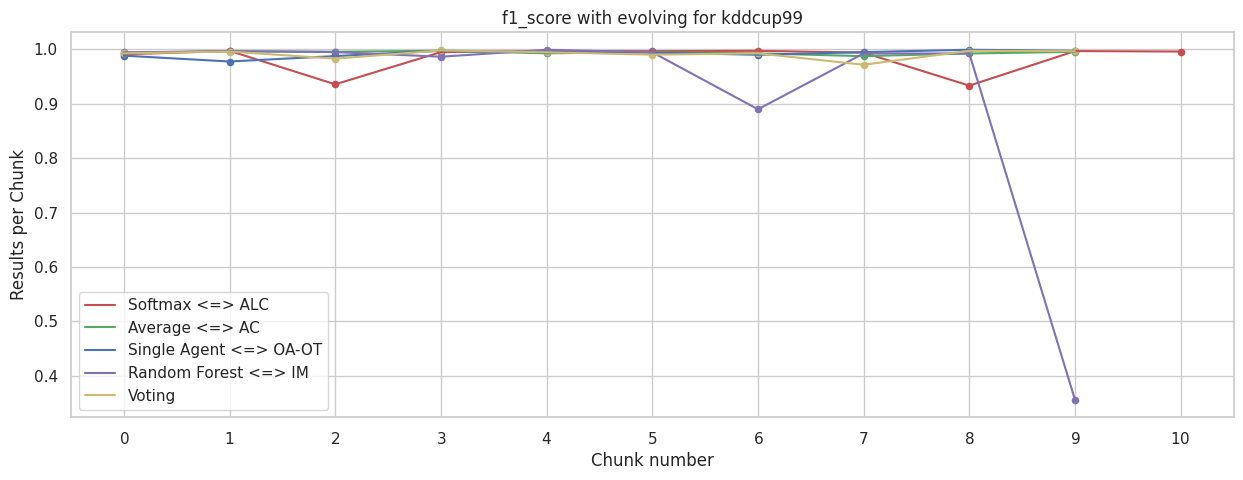

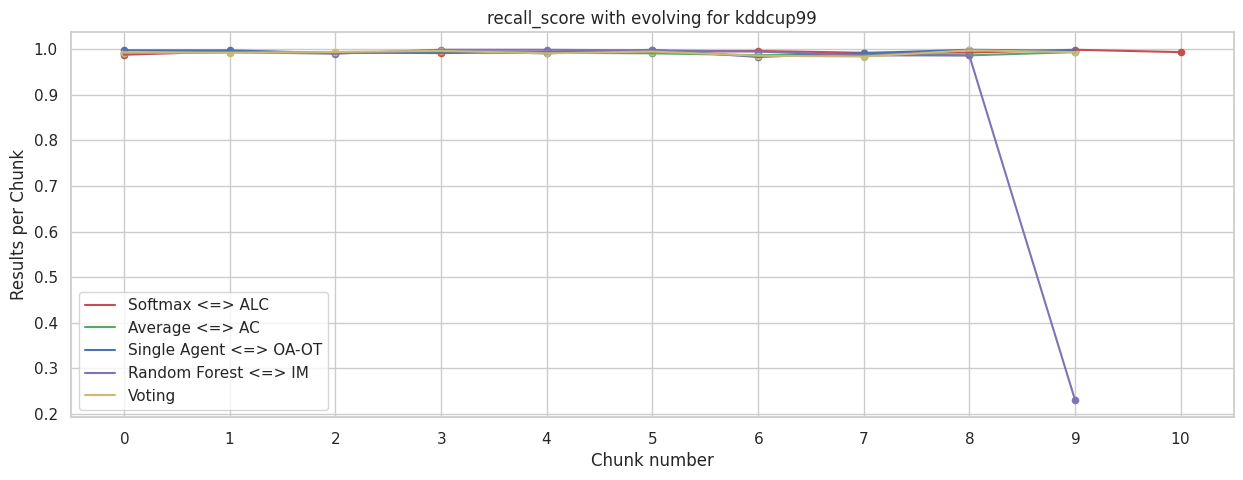

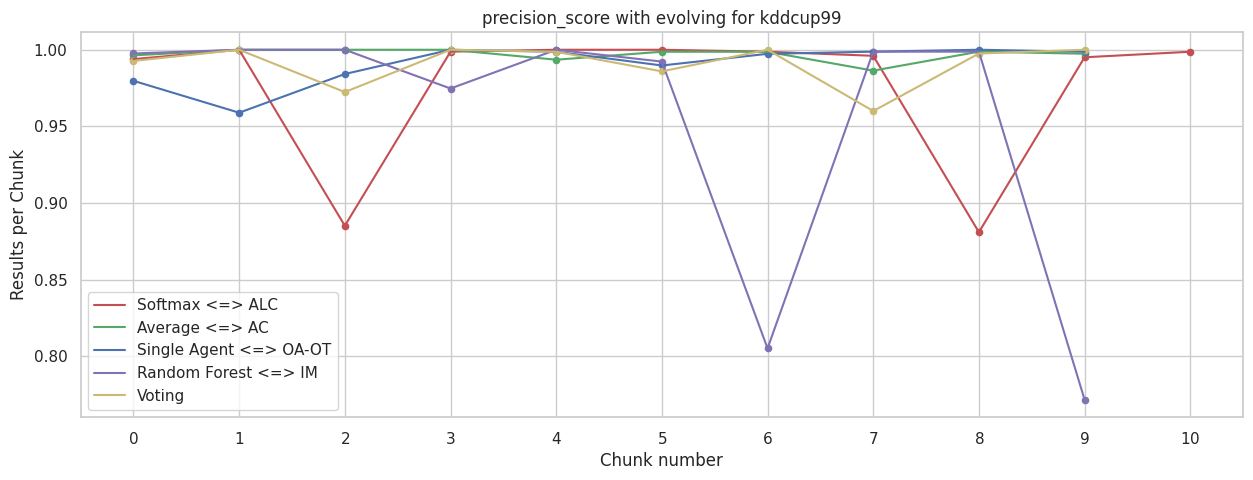

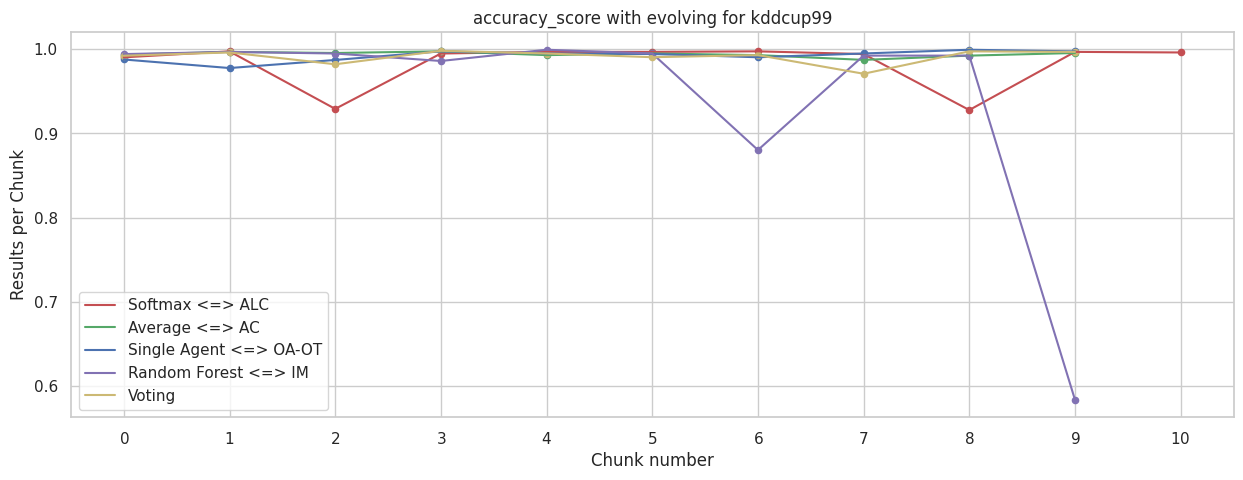

===================== dataset : ISCX2012 ======================


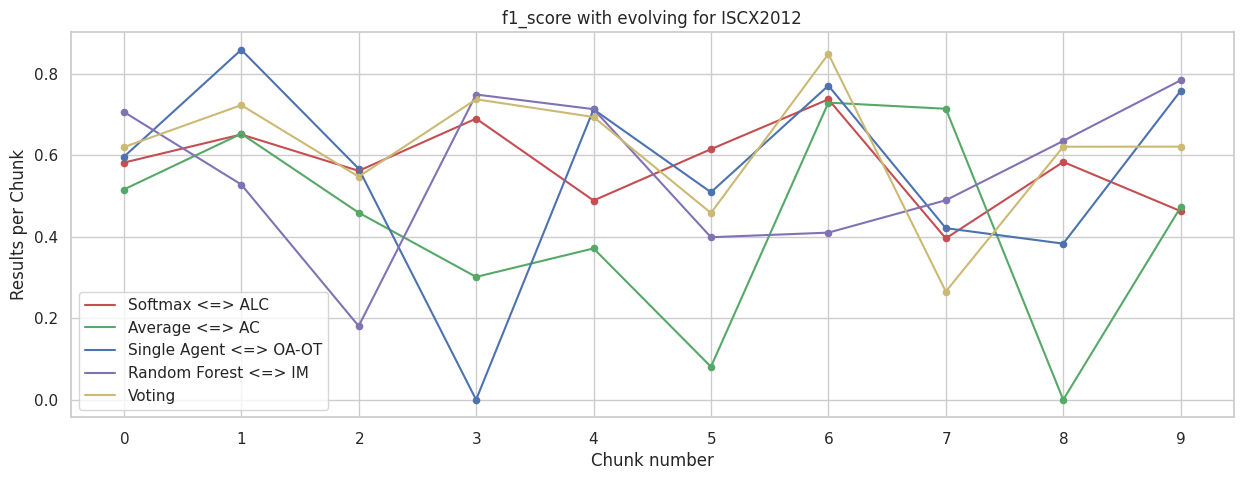

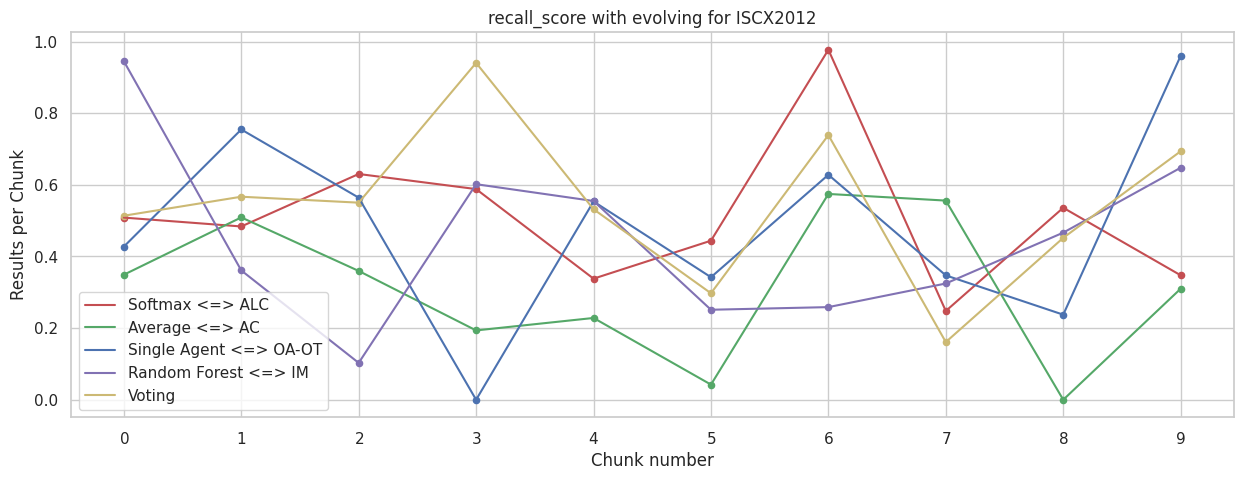

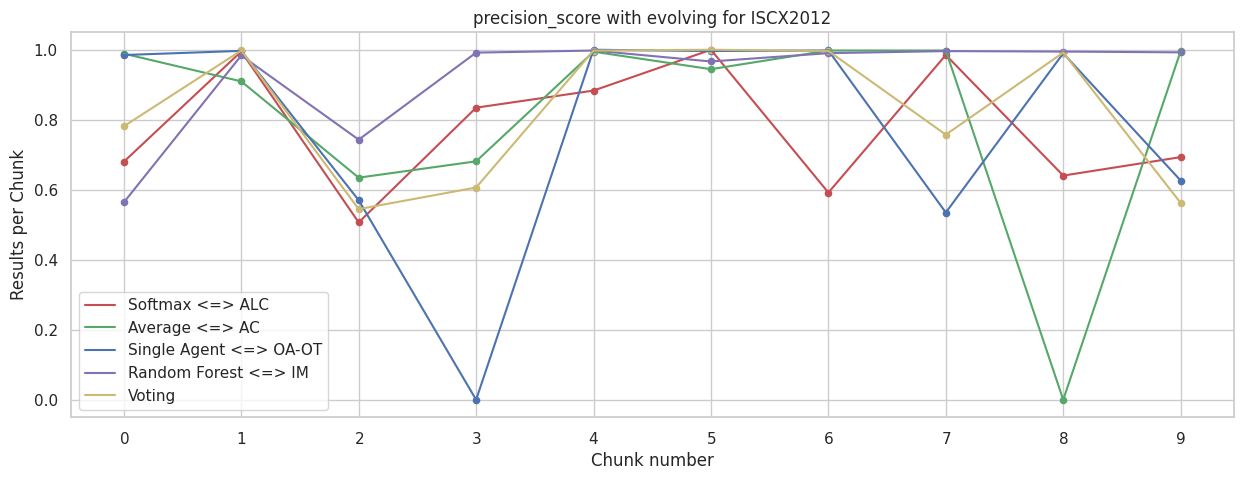

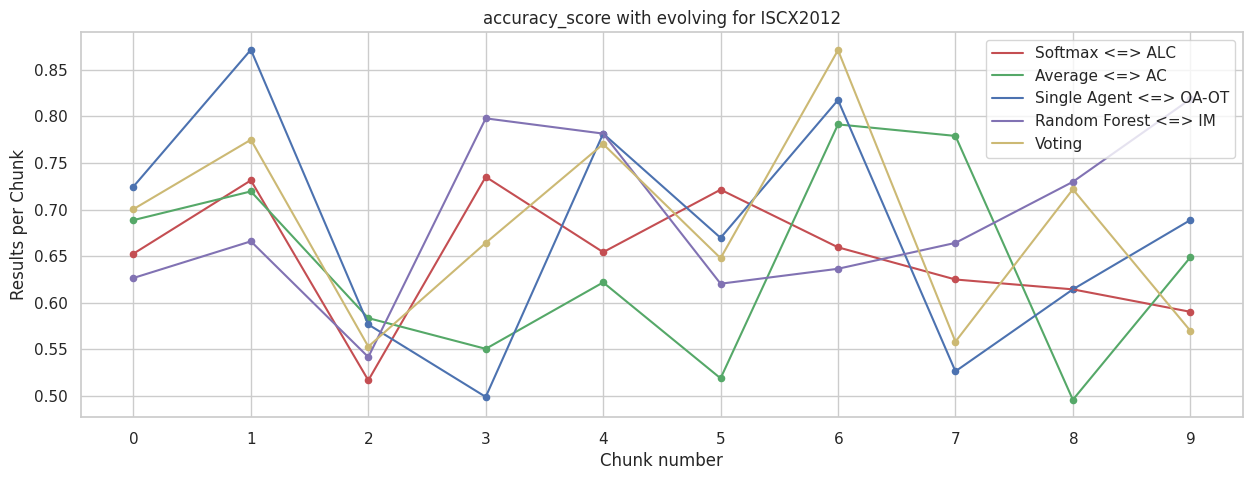

===================== dataset : CSE-CIC2018 ======================


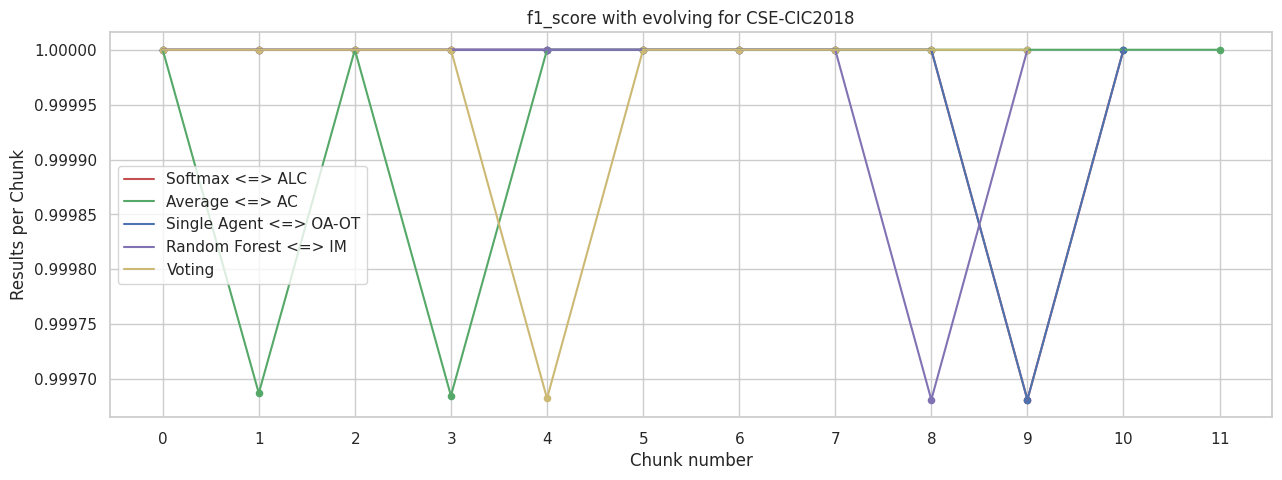

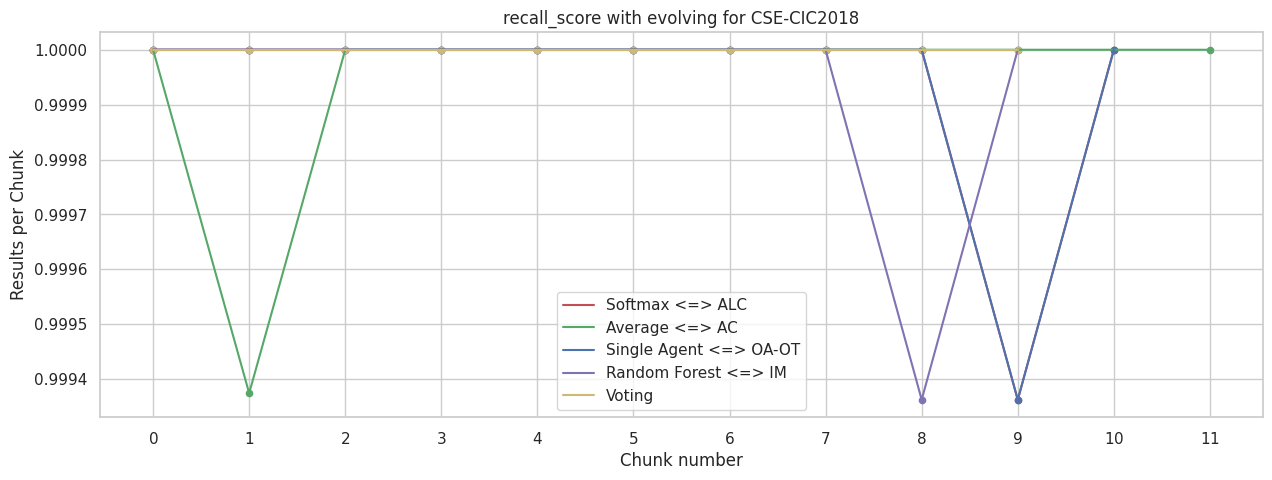

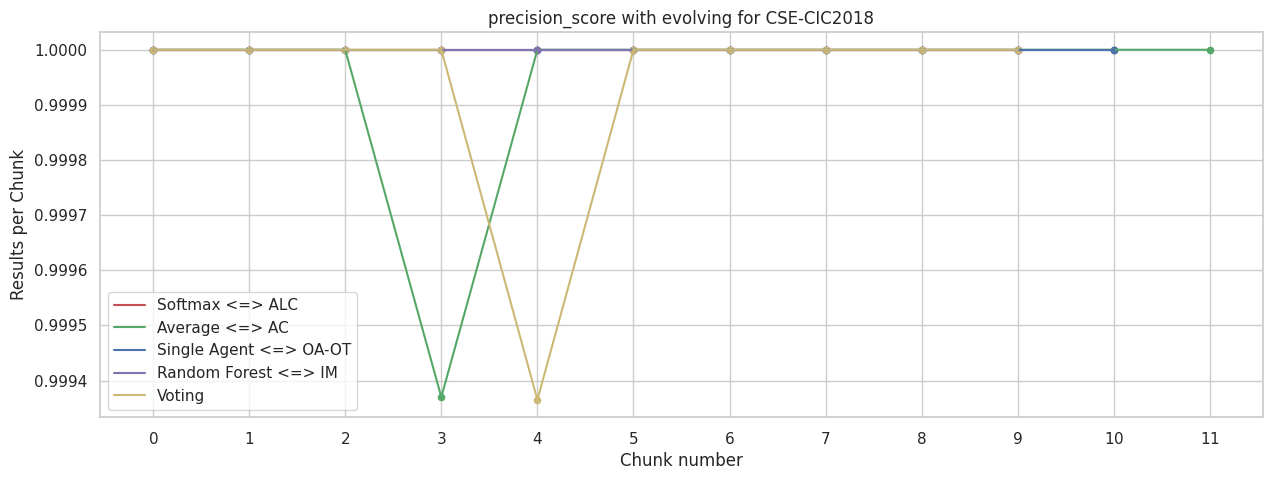

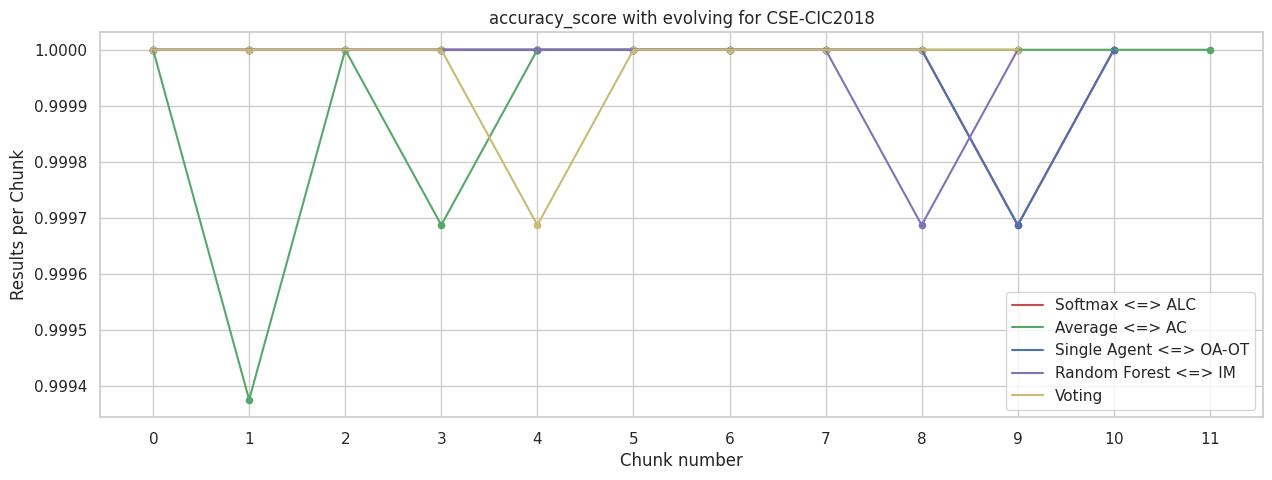

===================== dataset : CICIDS2017 ======================


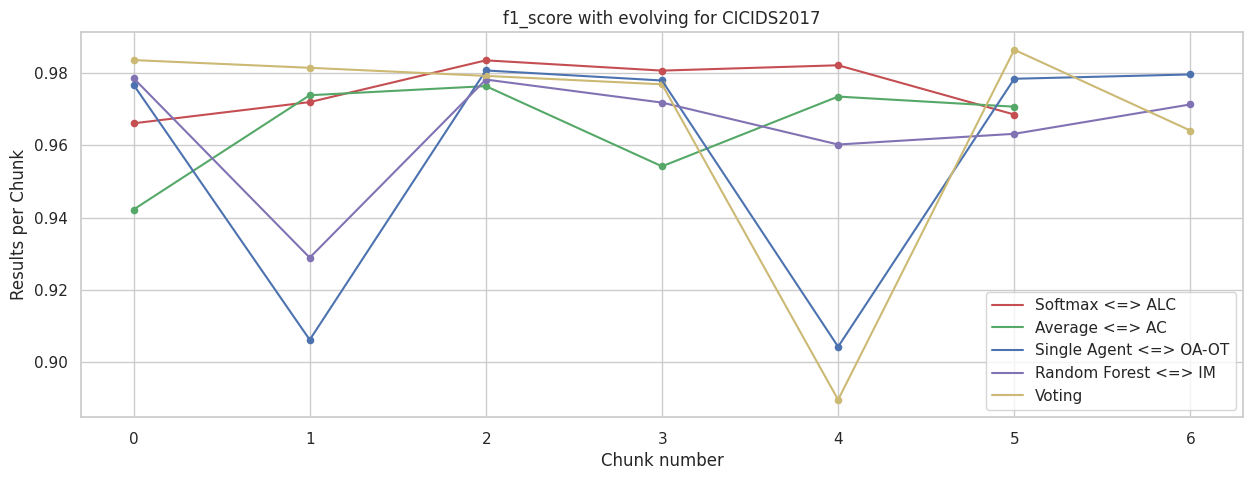

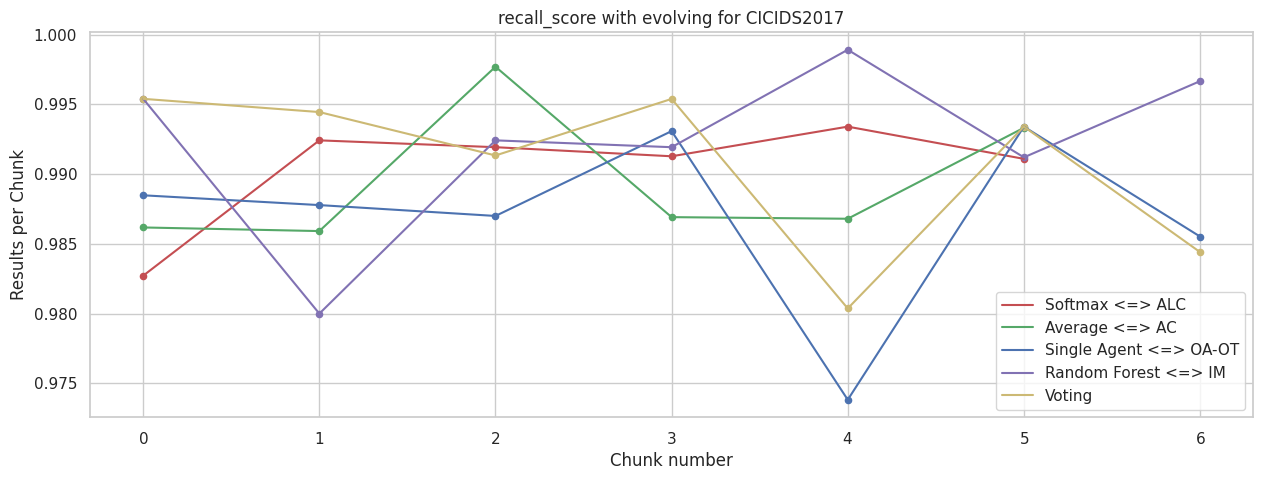

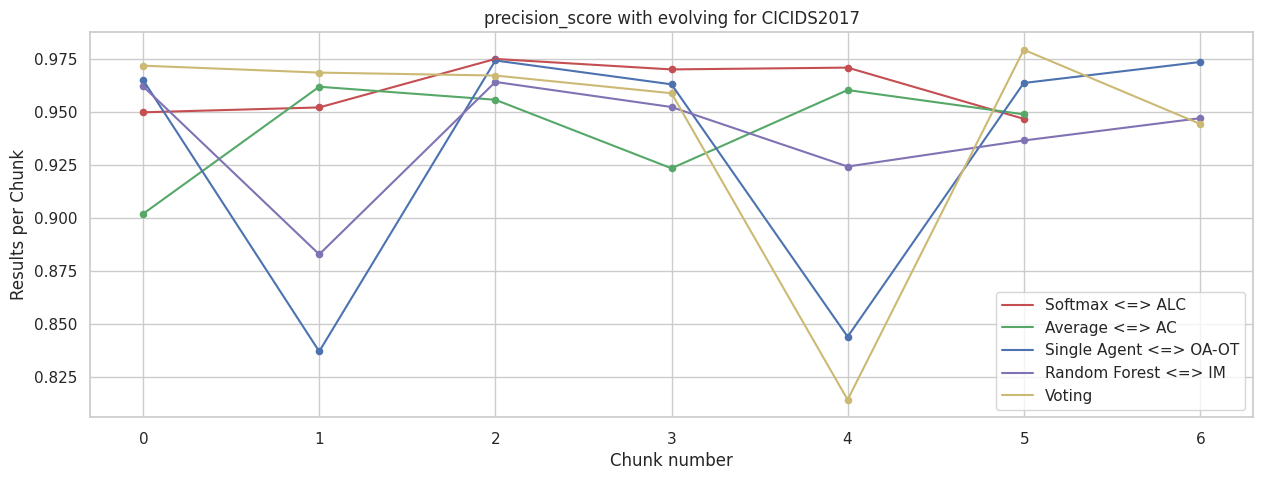

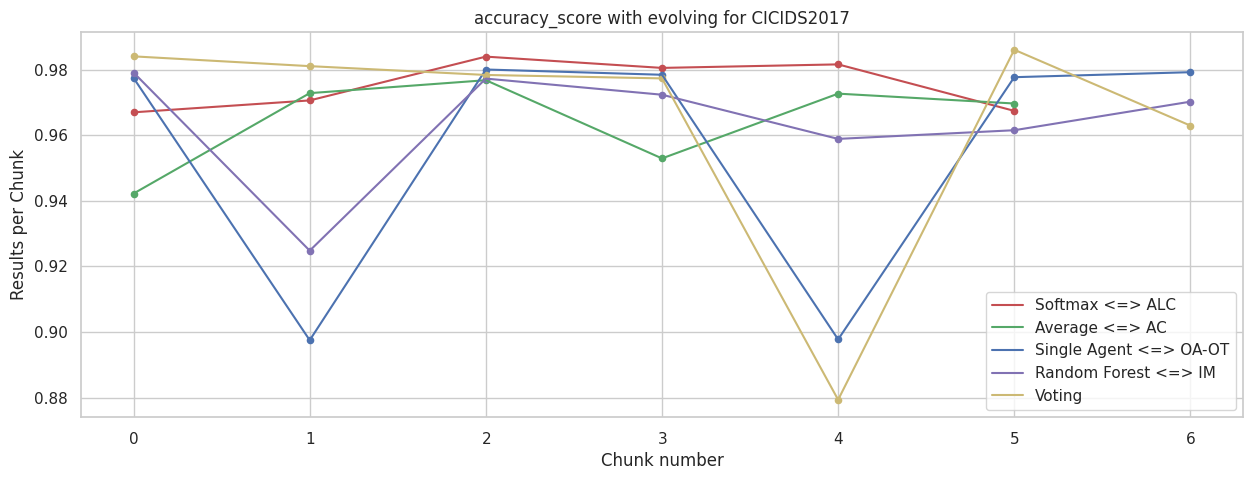

In [ ]:
for d_name in data_name[:4]:
  load_path = os.path.join(feature_selection_results,d_name)
  save_path = os.path.join(os.path.join(feature_selection_results,'Images'),d_name)
  softmax_results = load_object("softmax_results",load_path)
  average_results = load_object("average_results",load_path)
  single_agent_results = load_object("single_agent_results",load_path)
  random_forest_results = load_object("random_forest_results",load_path)
  voting_results = load_object("voting_results",load_path)
  os.makedirs(save_path, exist_ok=True)
  print("===================== dataset : {} ======================".format(d_name))
  for i,metric_name in enumerate(list(softmax_results.keys())[:-1]):
    plot_results(save_path,metric_names[i]+" with evolving"+" for "+d_name, methods_name, [softmax_results[metric_name],average_results[metric_name],single_agent_results[metric_name],random_forest_results[metric_name],voting_results[metric_name]], colors, step=1)